<a href="https://colab.research.google.com/github/SURESHBEEKHANI/Advanced-LLM-Fine-Tuning/blob/main/Llama_3_8B_dpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Fine-Tuning Llama3 with Direct Preference Optimization (DPO)  

Welcome to Part 2 of our **Llama3 Fine-Tuning Series**.  

In the previous notebook, we explored **Supervised Fine-Tuning (SFT)** to fine-tune the Llama3-8B base model. In this notebook, we will take a different approach by utilizing **Direct Preference Optimization (DPO)** for fine-tuning.  

Stay tuned for the next installment, where we will introduce **ORPO**, a novel technique that seamlessly combines SFT and DPO into a unified process.


# Introduction to Finetuning with SFT and RLHF  

Finetuning involves taking a pre-trained LLM (e.g., Llama3 or Mistral7b) and tailoring its output for specific tasks, such as generating company-specific responses, formatting code, or optimizing performance in specialized fields.  

### Supervised Fine-Tuning (SFT)  
SFT trains a model on labeled input-output pairs, teaching it the "correct" output for a given input. It is highly effective when tasks are well-defined, and ample labeled data is available. However, SFT lacks a feedback loop—once training begins, the model doesn't receive ongoing performance evaluations.  

### Reinforcement Learning with Human Feedback (RLHF)  
RLHF enhances SFT by introducing a trained "reward model" that mimics human feedback. This model scores LLM completions and uses the **Proximal Policy Optimization (PPO)** algorithm to refine outputs based on preferences. While RLHF adds valuable feedback, it is computationally expensive, requires more data, and PPO can be unstable and difficult to reproduce.  


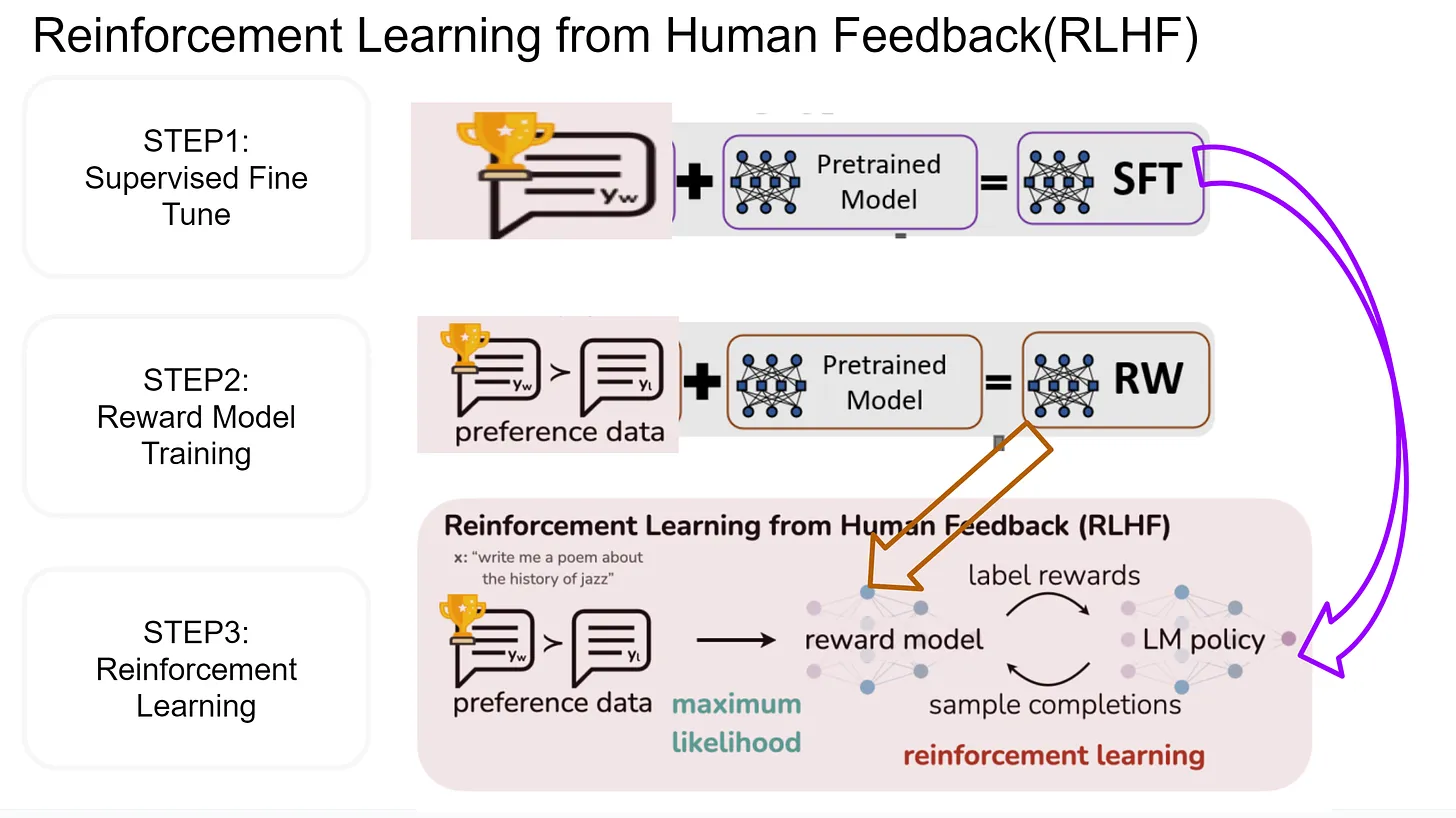

# How Does DPO Improve Finetuning?  

**Direct Preference Optimization (DPO)** addresses many of the limitations of RLHF by reframing the task as a classification problem.  

### Key Features of DPO:  
1. **Dual-Model Approach**:  
   - DPO uses two models: the trained model and a reference model (a copy of the original).  
   - During training, the goal is to ensure the trained model assigns higher probabilities to preferred answers and lower probabilities to rejected answers compared to the reference model.  

2. **Elimination of a Separate Reward Model**:  
   - Instead of relying on a separate reward model, the LLM effectively acts as its own reward system.  
   - This removes the need for extensive sampling, hyperparameter tuning, or training an additional reward model.  

3. **Efficiency and Stability**:  
   - By simplifying the process, DPO is more computationally efficient and stable than RLHF.  

### Two-Stage Process:  
Although DPO introduces improvements, it still relies on a two-stage approach:  
1. **Supervised Fine-Tuning (SFT)**  
2. **Direct Preference Optimization (DPO)**  


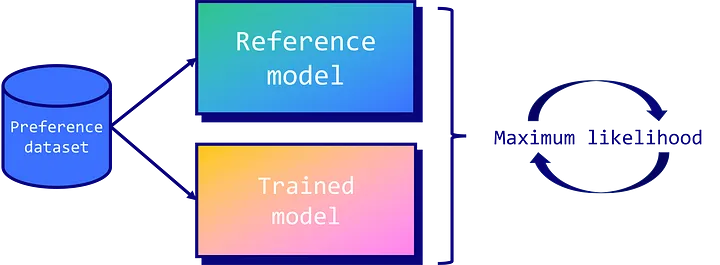

### Install dependencies

In [ ]:
# Install all required libraries for dataset handling, finetuning, and model optimization in one command
!pip install datasets trl peft bitsandbytes wandb accelerate transformers


In [ ]:
# Import the `notebook_login` function from the Hugging Face Hub library
# This function allows you to log in to your Hugging Face account directly from the notebook
from huggingface_hub import notebook_login

# Prompt the user to log in to their Hugging Face account
# Logging in enables access to private models, datasets, and other features on the Hugging Face Hub
notebook_login()


In [ ]:
# Import standard library modules
import os  # For interacting with the operating system, such as file management
import gc  # For garbage collection to manage memory during model training

# Import torch library for tensor operations and model handling on GPUs
import torch

# Import transformers library for working with transformer models (e.g., GPT, BERT, etc.)
import transformers

# Import specific classes and functions from transformers
from transformers import (
    AutoModelForCausalLM,  # Class to load a causal language model (e.g., GPT-style models)
    AutoTokenizer,  # Class to automatically load the appropriate tokenizer for a given model
    TrainingArguments,  # Class for configuring training parameters like batch size, learning rate, etc.
    BitsAndBytesConfig  # Configuration for 8-bit/4-bit quantization of models to optimize memory usage
)

# Import datasets library for loading and handling datasets
from datasets import load_dataset

# Import specific modules from `peft` (Parameter-Efficient Fine-Tuning)
from peft import (
    LoraConfig,  # Configuration for Low-Rank Adaptation (LoRA) fine-tuning technique
    PeftModel,  # Class for parameter-efficient fine-tuning models
    get_peft_model,  # Function to retrieve a PEFT model based on the configuration
    prepare_model_for_kbit_training  # Prepares a model for training with low-bit precision (e.g., 4-bit or 8-bit)
)

# Import modules from the `trl` library for reinforcement learning with transformers
from trl import DPOTrainer, setup_chat_format  # DPOTrainer for training with Direct Preference Optimization, setup_chat_format for formatting input data

# Import the `bitsandbytes` library for 8-bit quantization to reduce model memory usage during training
import bitsandbytes as bnb


# Load the Model and Tokenizer

Note that we also load a reference model for completeness. If we do not provide one, the `DPOTrainer` will automatically create one for us.


In [ ]:
# Define the name of the pre-trained base model to load from Hugging Face Hub
# This model is Meta's Llama 3 with 8B parameters, fine-tuned for instruction-based tasks
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"

# Define the name for the new model, which will be fine-tuned using Direct Preference Optimization (DPO)
# This is the custom model we will save or use after training
new_model = "DPO-Llama-3-8B"
